# Classifying customer reviews for complaints using Watson NLP

This notebook demonstrates how to train text classifiers using Watson NLP. The classifiers predicts the complaints from the text of a customer reviews. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is the data scraped from Booking.com. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe.
A reviews contains the customer’s narrative description of their experience. In this notebook, you will focus on classifying the reviews as complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe. The dataset has been downloaded and saved on the [GitHub](https://ibm.box.com/shared/static/u88jxenp0ia7q9e0ac5d84xqf3vak1mm.csv) for you.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a custom SVM model** using `watson_nlp.blocks.classification.SVM`. SVM stands for Support Vector Machines. It's an established classification method. We will run it based on USE (Universal Sentence Encoder) embeddings of the input text.
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.Ensemble`. The Ensemble model combines three classification models: CNN, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.	[Data Processing](#prepareData)
    1. [Prepare training and test data](#prepareTraining)
1.  [Model Building](#buildModel)
    1. [Train a SVM classification model with Watson NLP](#svm)
    1. [Train an ensemble classification model with Watson NLP](#ensemble)
    1. [Store and load classification models](#storeLoad)
1.  [Model Evaluation](#evaluate)
1.  [Summary](#summary)

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
import watson_nlp
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp
from datetime import datetime

In [5]:
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.workflows.classification import Ensemble
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

<a id="loadData"></a>
## Data Loading (customer complaint data)

The data can be downloaded from https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe. The data is exported in CSV format.

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe.

In your analysis you will focus on the *Negative_Review* column and *Positive_Review* column, which contains the customer review text.

<span style="color:blueviolet">We load the customer review dataset into a DataFrame.</span>

<span style="color:blue">This data set contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe.</span>

In [6]:
# load data set into a dataframe
buffer = project.get_file("Hotel_Reviews.csv")
complaint_df = pd.read_csv(buffer)

# preview the data set
complaint_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the ...,397,1403,Only the park outside of the hotel was beautiful,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellen...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 4 nights ']",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge,42,1403,Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back,21,9,7.1,"[' Leisure trip ', ' Family with young children ', ' Duplex Double Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in m...,210,1403,Great location in nice surroundings the bar and restaurant are nice and have a lovely outdoor area The building also has quite some character,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex Double Room ', ' Stayed 3 nights ']",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line you showed me pictures of a room I thought I was getting and paying for and then when we arrived that s room was booked and the staff told me we could only book the villa suite theough them directly Which was completely false advertising After being there we realised that you have grouped lots of rooms on the photos together leaving me the consumer ...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",10 days,52.360576,4.915968


In [7]:
complaint_df['Negative_Review'][1]


'No Negative'

In [9]:
complaint_df.loc[complaint_df['Positive_Review'] == 'No Positive', 'review_type'] = 'Complaint'
complaint_df.loc[complaint_df['Negative_Review'] == 'No Negative', 'review_type'] = 'Non-Complaint'


In [10]:
complaint_df['review_type'].value_counts()

Non-Complaint    127890
Complaint         35819
Name: review_type, dtype: int64

In [11]:
complaint_df['review_type'].isna().sum()

352029

In [12]:
complaint_df.loc[:, 'Positive_Review'] = complaint_df.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
complaint_df.loc[:, 'Negative_Review'] = complaint_df.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

In [13]:
complaint_df['Negative_Review'][1]


''

In [14]:
complaint_df['review'] = complaint_df.Positive_Review + complaint_df.Negative_Review


In [21]:
complaint_reviews = complaint_df[complaint_df.review_type == "Complaint"]
non_complaint_reviews = complaint_df[complaint_df.review_type == "Non-Complaint"]


In [23]:
RANDOM_SEED = 123

non_complaint_df = non_complaint_reviews.sample(n=len(complaint_reviews), random_state=RANDOM_SEED)

df_review_resampled = non_complaint_df.append(complaint_reviews).reset_index(drop=True)
df_review_resampled.shape

(71638, 19)

In [24]:
complaint_df = df_review_resampled[["review", "review_type"]]


In [25]:
complaint_df['review_type'].value_counts()

Non-Complaint    35819
Complaint        35819
Name: review_type, dtype: int64

<a id="prepareData"></a>
## 3. Data Processing & EDA

In [26]:
complaint_df['review_type'].value_counts()

Non-Complaint    35819
Complaint        35819
Name: review_type, dtype: int64

<a id="prepareTraining"></a>
## 3.A Prepare training and test data

In [27]:
train_test_df = complaint_df

<span style="color:blueviolet">In the next step, you will split the data into training and test data (ratio:80/20).</span>

In [28]:
# 80% training data
train_orig_df = train_test_df.groupby('review_type').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['review_type'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['review_type'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 57310
Samples by product group:
Complaint        28655
Non-Complaint    28655
Name: review_type, dtype: int64

Test data:
Number of test samples: 14328
Samples by product group:
Non-Complaint    7164
Complaint        7164
Name: review_type, dtype: int64


You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

<span style="color:blueviolet">In the sample, you will create the data in *JSON* format. The training and test data is written to files.</span>

In [29]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[['review', 'review_type']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={"review": "text", 'review_type': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,The Bathroom Walls but this is not something that could be fixed,[Complaint]
1,Very noisy until 2am the ppl getting out the nearby pubs then after 2am it was our neigburgh from room upstairs time to get double windows,[Complaint]


<a id="buildModel"></a>
## 4. Model Building

<a id="svm"></a>
## 4.A Train a SVM classification model with Watson NLP

SVM is an established classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [30]:
# Syntax Model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# USE Embedding Model
use_model = watson_nlp.load(watson_nlp.download('embedding_use_en_stock'))

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [31]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

<span style="color:blueviolet">Train the classifier</span>. **Note:** This cell will run for several minutes.

In [32]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)
# svm_model_small = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## 4.B Train an ensemble classification model with Watson NLP

The ensemble model combines three classification models: 

- CNN 
- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 

It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the GloVe and USE embeddings. They are passed with the file containing the training data.

<span style="color:blueviolet">Train the ensemble classifier.</span> **Note:**  This cell will run for several minutes. To restrict the time, we limited the epochs to train the CNN classifier to 5. This is an optional attribute - if not specified, the default will be 30 epochs.

In [33]:
stopwords = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock')

ensemble_model = Ensemble.train(train_file, 'syntax_izumo_en_stock', 'embedding_glove_en_stock', 'embedding_use_en_stock', stopwords=stopwords, cnn_epochs=5)

Epoch 1/5
896/896 - 623s - loss: 0.5079 - categorical_accuracy: 0.9182 - 623s/epoch - 696ms/step
Epoch 2/5
896/896 - 623s - loss: 0.2347 - categorical_accuracy: 0.9429 - 623s/epoch - 695ms/step
Epoch 3/5
896/896 - 624s - loss: 0.2196 - categorical_accuracy: 0.9461 - 624s/epoch - 697ms/step
Epoch 4/5
896/896 - 624s - loss: 0.2027 - categorical_accuracy: 0.9509 - 624s/epoch - 697ms/step
Epoch 5/5
896/896 - 626s - loss: 0.1944 - categorical_accuracy: 0.9525 - 626s/epoch - 699ms/step


<a id="storeLoad"></a>
## 4.C Store and load classification models (optional)

You can save a model as a project asset. `model.as_file_like_object()` creates a ZIP archive, which is provided as a *BytesIO* object that is stored in the project.

**Note:** These steps are **optional**. You can skip them, and continue at [Classify test data and compare model quality](#scoring)

<span style="color:blueviolet">Save both models in your project.</span>

In [34]:
project.save_data('svm_model_hotel_reviews_classification', data=svm_model.as_file_like_object(), overwrite=True)

{'file_name': 'svm_model_hotel_reviews_classification',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': 'a6692e7c-c7b8-4b61-ae0e-5a66c753ad80'}

In [35]:
project.save_data('ensemble_model_hotel_reviews_classification', data=ensemble_model.as_file_like_object(), overwrite=True)

{'file_name': 'ensemble_model_hotel_reviews_classification',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': '6d8e4c17-7d0b-4546-9eee-5ad529b5de2b'}

<span style="color:blue">The ZIP archive created by the `save_data` function is compatible to the `watson_nlp.load()` function that is also used to load the predefined Watson NLP models.</span>

In [36]:
# svm_model = watson_nlp.load(project.get_file('svm_model'))

In [37]:
# ensemble_model = watson_nlp.load(project.get_file('ensemble_model'))

<a id="evaluate"></a>
## Model Evaluation

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the SVM model requires you to run the syntax model on the input texts first.

<span style="color:blueviolet">Create a helper method to run both models on a single complaint and return the predicted product groups of both models.</span>

In [38]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)

<span style="color:blueviolet">Run the models on the complete test data.</span>

In [39]:
text_col = 'review'

In [40]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
# predictions_df = pd.DataFrame.from_records(predictions, columns='Predicted SVM')

result_df = test_orig_df[[text_col, "review_type"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

,review,review_type,Predicted SVM,Predicted Ensemble
0,The staff was really well listening to our concerns,Non-Complaint,Non-Complaint,Non-Complaint
1,Staff very friendly and helpful hotel immaculate,Non-Complaint,Non-Complaint,Non-Complaint
2,Everything was perfect Staff amazing friendly professional helpful Rooms spot on Just a wonderful hotel Price of drinks etc a little high but not too bad for such a top hotel,Non-Complaint,Non-Complaint,Non-Complaint
3,Great size room and clean,Non-Complaint,Non-Complaint,Non-Complaint
4,Great for Location Staff Value for money,Non-Complaint,Non-Complaint,Non-Complaint


### Creating and plotting a confusion matrix

In [41]:
# confusion matrix in sklearn
from sklearn.metrics import classification_report

# actual values
actual = result_df['review_type']
# predicted values
predicted_svm = result_df['Predicted SVM']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_svm,labels=['Non-Complaint', 'Complaint'])
# matrix = classification_report(actual,predicted_svm,labels=['bad', 'good', 'excellent'])

print('Classification report for SVM classifier: \n',matrix)

Classification report for SVM classifier: 
                precision    recall  f1-score   support

Non-Complaint       0.95      0.94      0.94      7164
    Complaint       0.94      0.95      0.94      7164

     accuracy                           0.94     14328
    macro avg       0.94      0.94      0.94     14328
 weighted avg       0.94      0.94      0.94     14328



In [42]:
predicted_ensemble = result_df['Predicted Ensemble']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_ensemble,labels=['Non-Complaint', 'Complaint'])
# matrix = classification_report(actual,predicted_ensemble,labels=['bad', 'good', 'excellent'])

print('Classification report for Ensemble classifier: \n',matrix)

Classification report for Ensemble classifier: 
                precision    recall  f1-score   support

Non-Complaint       0.95      0.95      0.95      7164
    Complaint       0.95      0.95      0.95      7164

     accuracy                           0.95     14328
    macro avg       0.95      0.95      0.95     14328
 weighted avg       0.95      0.95      0.95     14328



<span style="color:blue">You can see that the precision, recall and f1-measure for some are approximately 0.95.</span>

<span style="color:blueviolet">Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.</span>

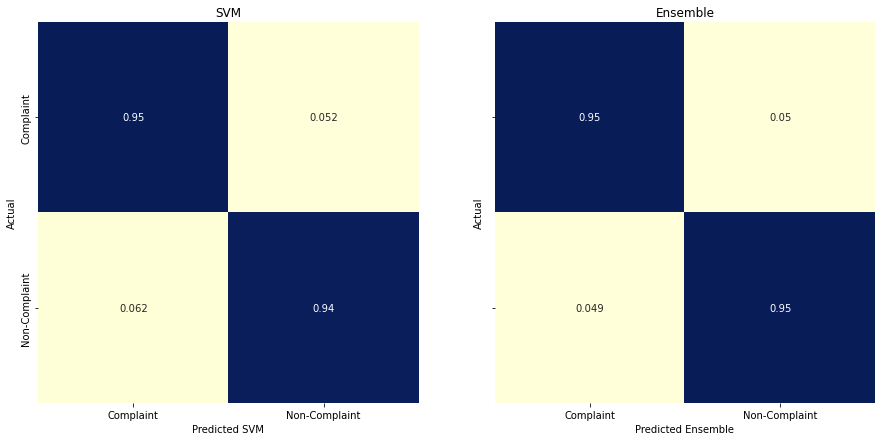

In [43]:
import seaborn as sn

SVM_confusion_df = pd.crosstab(result_df['review_type'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['review_type'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# figure, ax1 = plt.subplots(ncols=1, figsize=(7,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

<span style="color:blue">In the confusion matrix for the SVM model you can now see that customer reviews can be classified as `Complaint` vs `Non-Complaint` with a very high accuracy.</span>

<span style="color:blue">Overall, the ensemble model performs at par with the SVM model. However, the SVM model had a significantly shorter training time. 

In subsequent steps, consider increasing the size of the training data, tuning the CNN training parameters or adjusting the  weights of the ensemble model to gain better results.</span>

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 